### Notebook for analysing nf pipeline output

#### Nanoseq 1a

### Sequencing information 
 - Analysis no.: A006
 - Platform: Nanoseq
 - Library preparion: NEBNext
 - Loaded: 12pM
 - Seq Date: 01-07-2021
 - Number of samples:96
 - Cluster Density: 
 - Passing Filter: 
 - Output: 77.4g
 - Fragment size: 550
 - Lib conc: 
 - Cubit 
 - Lib load start concentration: 

TypeError: no numeric data to plot

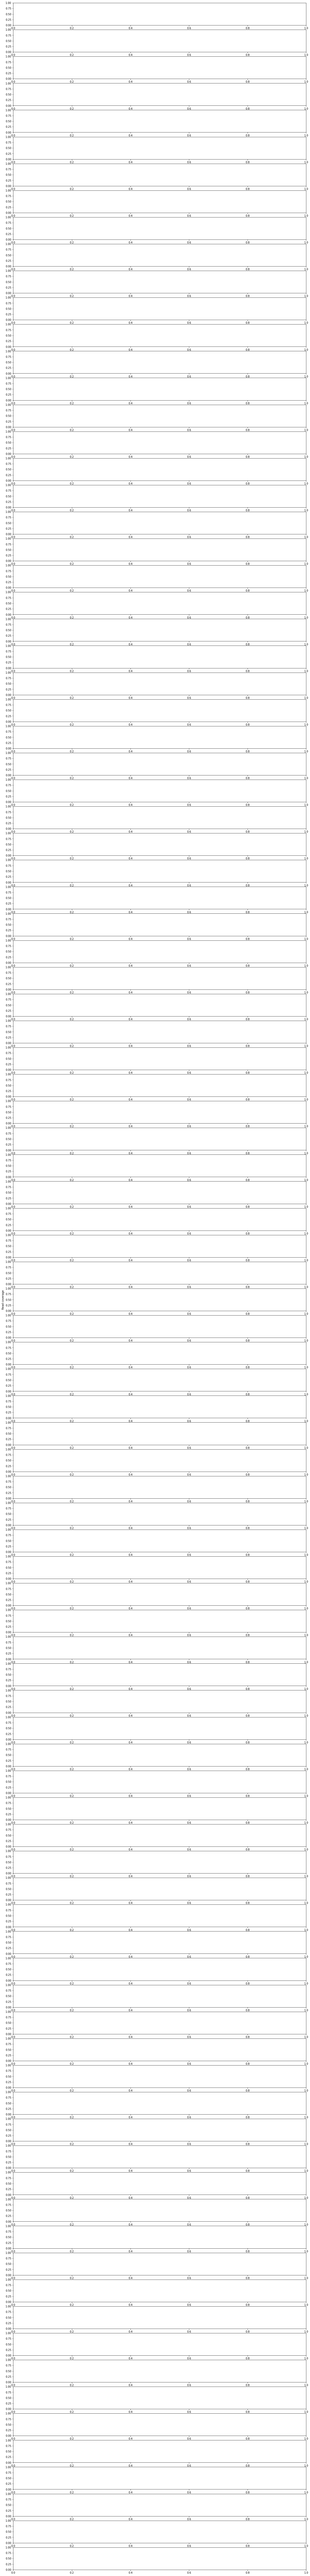

In [355]:
# plot primer depths across samples-GK
import pandas as pd, matplotlib.pyplot as plt, numpy as np, os

suffix = '.coverage.tsv'
base_dir = '/home/douso/nano/seq1/dpt_g'
files = os.listdir(f'{base_dir}')
data = []
for file in files:
    if file.endswith(suffix):
        data.append(file)
    else: pass
a = len(data)
b, c = 1, -1

fontdict = {'family': 'serif',
        'color':  'lightblue',
        'weight': 'normal',
        'size': 16,
        }

fig, axs = plt.subplots(a, b, figsize=(20,180)) 
axs[int(a/2)].set_ylabel('Read coverage')
# axs[1].set_title('Genome coverage by base')
xtick = np.arange(0, 30200, 200)
xlabel = np.arange(0, 30200, 200)

for file in sorted(data):
    c += 1
    sample_name = file.split('.')[0]
    sample_df = pd.read_table(f'{base_dir}/{file}', names=['chromosome', 'region', 'coverage'])
    sample_df2 = sample_df[['region', 'coverage']]
    sample_df2.plot(logy=True, ax=axs[c], sharex=True, sharey=False) 
    axs[c].legend([sample_name], loc='upper left')

plt.xlabel('Genome nucleotide position')
# plt.ylabel('Read coverage')
plt.xticks(xtick, xlabel, rotation=90)
plt.tight_layout()
plt.show()
fig.savefig(f'{base_dir}/coverage.pdf')


## Packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import glob

In [3]:
base_dir = '/home/douso/nano/seq1'
batch = 'nanoseq1'
# dpt_dir = # ivar, samtools-depth output files
# nxt_dir = # nextclade .tsv output file
# png_dir = # pangolin .tsv output file
# var_dir = # snpEff ouput
# rmd_dir = # raw metadata - moh .xlsx spread sheet
#dpt var nxt png

### Sequencing information 
 - Analysis no.: NF-004 (batch 10)
 - Platform: Illumina MiSeq
 - Library preparion: NEBNext
 - Seq Date: MiSeq (28-05-2021)
 - Number of samples: 96
 - Sample summ: COVCs
 - VC pipeline: nextflow-viralcon, v1.0.1

## Functions

In [4]:
# define a func to replace spaces in the header names
def tidy_header(df):
    df.columns = [col.replace(' ', '_') for col in df.columns]
    return df

In [5]:
# define func to retrieve particular columns from a df (spaces in col names must be replaced with _ in the input col_list)
def get_cols(df, col_list):
    new_df = tidy_header(df)
    return new_df[col_list]

In [6]:
# define a function to replace from a dictionary ('key is what is to be replaced': 'value is the replacement')
def replace(string, substitutions):
    substrings = sorted(substitutions, key=len, reverse=True)
    regex = re.compile('|'.join(map(re.escape, substrings)))
    return regex.sub(lambda match: substitutions[match.group(0)], string)

In [7]:
# define function to merge variants and nextclade data
def merge_varNxt(df_var_cln, df_nxt_cln):
    return (df_var_cln.set_index('sample_name').merge(df_nxt_cln
          .set_index('seqName'), how='outer', left_index=True, right_index=True)
                 .reset_index().rename(columns={'index': 'sample_name'}))

In [8]:
# define function to merge pangolin and variants-nextclade data
def merge_pngVxt(df_png_cln, df_varNxt):
    return (df_png_cln.set_index('Sequence_name').merge(df_varNxt
        .set_index('sample_name'), how='outer', left_index=True, right_index=True)
            .reset_index().rename(columns={'index': 'Sequence_name'}))


In [9]:
# define function to merge metadata with cts data
def merge_rmdCts(df_rmd_cln, df_cts_cln):
    return (df_rmd_cln.set_index('S_NUM').merge(df_cts_cln.set_index('Sample_Name'), how='outer', left_index=True, right_index=True)
            .reset_index().rename(columns={'index': 'S_NUM'}))


In [10]:
# define function to merge metadata and seq data
def merge_vnpPmd(df_pngVxt, df_rmdCts):
    return (df_pngVxt.set_index('S_NUM')
            .merge(df_rmdCts.set_index('S_NUM'), how='left', left_index=True, right_index=True)
                 .reset_index().rename(columns={'index': 'S_NUM'}))

In [11]:
# define a function to retrieve MoC and all mutations for the s-gene
def get_mut_of_concern(ann_file_name, moc_list):

    def intersection(x, y):
        return list(set(x) & set(y))

    moc_list = moc_list
#     file_name = 'k-per-gene_variant_anns.tsv'
    df = ann_file_name[['sample_name','S']]

#     df = pd.read_table(f'{base_dir}/{file_name}')[['sample_name','S']]
    mutations = []
    moc = []
    sample_id = []
    for row in df.itertuples():
        if isinstance(row.S, str):
            sgene = row.S
        else: 
            sgene = str(row.S)
        substitutions = sgene.replace(' ', '').split(',')[1:-1]
        if len(moc_list) >= len(intersection(moc_list, substitutions)) > 0:
            intsct = intersection(moc_list, substitutions)
            sample_name = row.sample_name
            mutations.append(str(substitutions).replace("[", "").replace("]", "").replace("'", ""))
            moc.append(str(intsct).replace("[", "").replace("]", "").replace("'", ""))
            sample_id.append(sample_name)
        else: pass 
    df = pd.DataFrame({'Sample_ID': sample_id, 'Mut_of_Concern_(S)': moc, 'All_Mutations_(S)': mutations})
    df_fnl = df.assign(Sample_ID = df['Sample_ID'].apply(lambda x: x.replace('_', '-').split('/')[0]))
    return df_fnl

### Variants data

In [12]:
# import the collated file for all the snpEff outputs
df_var = pd.read_table(f'{base_dir}/var/k-per-gene_variant_anns.tsv')
df_var_fnl = df_var.assign(sample_name = df_var['sample_name'].apply(lambda x: x.replace('_', '-').split('/')[0]))

In [13]:
df_var_fnl.head()

,sample_name,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10
0,COVC16120,19,"T265I, R402R, F924F, P1541S, T2183I, T2183I, L...",NaN,"K182R, N501Y, D614G","V13L, Q57H, E241D",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"S194L, R195K, L222L, D415D, D415D",NaN,NaN,NaN
1,NHRL-S005,21,"N126N, T265I, F924F, F1907F, V2130I, K2622N, I...",NaN,"F562F, D614G, N679K, F888L",Q57H,NaN,NaN,F53F,NaN,NaN,NaN,NaN,"D22Y, R195K, S197L, T198P",NaN,NaN,NaN
2,COVC23686,28,"S216S, F924F, T1001I, A1708D, F1907F, I2230T, ...",NaN,"H69_V70del, Y145del, N501Y, A570D, D614G, P681...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Q27*, R52I, Y73C","D3L, RG203KR, S235F",NaN,NaN,NaN
3,COVC16160,6,"T265I, F924F, L4715L",NaN,D614G,"A23V, Q57H",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,COVC16129,11,"E102Q, T265I, F924F, L4715L, S5952L, Ter6271Ter",NaN,"D614G, P681H",Q57H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"P13S, E136E",NaN,NaN,NaN


### Nextclade data

In [14]:
# import Nextclade clade data
df_nxt = pd.read_table(f'{base_dir}/nxt/nxt.tsv')

# retrieve cols seqName and clade (func get_cols replaces col name spaces with _)
cols = ['seqName', 'clade', 'totalMissing']
df_nxt_cln = get_cols(df_nxt, cols)
coverage = round(100 - (df_nxt_cln['totalMissing'] / 29903) * 100, 1)
df_nxt_cln1 = df_nxt_cln.assign(seqName = df_nxt_cln['seqName'].apply(lambda x: x.replace('_', '-').split('/')[0]))
df_nxt_fnl = df_nxt_cln1.assign(coverage = coverage).drop('totalMissing', axis=1)

# df_nxt_fnl['seqName'].str.split('/')[0]

In [15]:
df_nxt_fnl.head()

,seqName,clade,coverage
0,COVC14674,20C,96.1
1,COVC14676,20C,96.1
2,COVC14699,20A,95.3
3,COVC14753,20B,80.2
4,COVC14784,20C,94.6


### Pangolin data v3.1.7 (15-07-2021) Ran: 13-07-2021

In [16]:
# import Pangolin lineage data
df_png = pd.read_csv(f'{base_dir}/png/png.csv', header=0)
# base_dir_pango = '/home/ouso/nextclade_files/batch2/nextclade_files_04-04-2021_11:25'
# file_name_pango = 'consensus_pango.xlsx'

# df_png = pd.read_excel(f'{base_dir_pango}/{file_name_pango}')
months = {'January': 'Jan', 'February': 'Feb', 'March': 'Mar',
         'April': 'Apr', 'June': 'Jun', 'July': 'Jul', 'August': 'Aug',
          'September': 'Sep', 'October': 'Oct', 'November': 'Nov', 'December': 'Dec'}
# retrieve cols Sequence_name and Lineage (func get_cols replaces col names spaces with _)
cols = ['Sequence_name', 'Lineage', 'Scorpio_call']#, 'Most_common_countries']
df_png_cln = get_cols(tidy_header(df_png), cols)
df_png_fnl = df_png_cln.assign(Sequence_name = df_png_cln['Sequence_name'].apply(lambda x: x.replace('_', '-').split('/')[0]))

# df_png_fnl = df_png_cln1.assign(Date_range=df_png_cln1['Date_range'].apply(lambda x: replace(x, months) if (isinstance(x, str)) else x))

In [17]:
df_png_fnl.head()

,Sequence_name,Lineage,Scorpio_call
0,COVC14674,B.1,NaN
1,COVC14676,B.1,NaN
2,COVC14699,B.1,NaN
3,COVC14753,B.1.530,NaN
4,COVC14784,B.1.103,NaN


# Metadata

In [18]:
# import raw metadata file
import pandas as pd
mbase_dir = '/home/douso/Documents/TrendData/Results/ResultsMerged'
df_rmd_cln = pd.read_excel(f'{mbase_dir}/COVID19-results-merged-cln.xlsx')

In [19]:
df_rmd_cln.head()

,S_NUM,AGE_YRS,GEND,OCCU,NAT,COUNT_RES,S_COUNT_RES,TRAV_HIST,TRAV_FROM,QUAR_PLACE,SYMPS,DT_SAM_COLL,DT_SAM_RECEP,RESULT,DT_CONF
0,COVC00001,35.0,F,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaT,Negative,2020-06-02 00:00:00
1,COVC00002,29.0,M,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaT,Negative,2020-06-02 00:00:00
2,COVC00003,50.0,M,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaT,Negative,2020-06-02 00:00:00
3,COVC00004,35.0,F,Casual,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaT,Negative,2020-06-02 00:00:00
4,COVC00005,27.0,F,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaT,Negative,2020-06-02 00:00:00


### Ct data

In [20]:
# import Ct data from sheet2 of the metadata file
ctbase_dir = '/home/douso/Documents/RunSheets/Cts'
df_cts = pd.read_excel(f'{ctbase_dir}/runsheet-cts.xlsx')

In [21]:
df_cts.head()

,Sample_Name,Well_Position,Dt_Run,Ct_Mean
0,COVC03200,E1,2020-07-08 16:06:36,17.1
1,COVC03592,E2,2020-07-08 16:06:36,31.0
2,COVC03602,A9,2020-07-08 16:05:06,31.6
3,COVC03607,B2,2020-07-08 16:05:06,30.6
4,COVC03608,G2,2020-07-09 14:46:29,34.2


### **Combining data**

#### Merge Variants and Nextclade data

In [22]:
# merge the nextclade data to the pangolin data
df_varNxt = merge_varNxt(df_var_fnl, df_nxt_fnl)

In [23]:
df_varNxt.head()

,sample_name,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10,clade,coverage
0,COVC14674,14,"E102Q, T265I, F924F, K2649R, K3353R, L4715L",NaN,"D614G, G798S","Q57H, P240L",NaN,NaN,NaN,NaN,NaN,NaN,R115L,"P13S, R195K, P207T",NaN,NaN,NaN,20C,96.1
1,COVC14676,15,"T265I, I841I, F924F, T999I, T4217I, L4715L, K5...",NaN,"S60S, D614G, Q675H",Q57H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"S186F, R195K, V270L",NaN,NaN,NaN,20C,96.1
2,COVC14699,18,"G728G, V757F, V757F, F924F, V4677I, L4715L, C5...",NaN,"I410I, D614G, A672A, P728P",NaN,NaN,NaN,L35L,NaN,NaN,NaN,NaN,"Q28R, S206F, T417I, T417I",NaN,NaN,NaN,20A,95.3
3,COVC14753,10,"F924F, Q1009R, V3595V, L4577F, L4715L, C5557F",NaN,"D614G, P681H",NaN,NaN,NaN,T9T,NaN,NaN,NaN,NaN,L400L,NaN,NaN,NaN,20B,80.2
4,COVC14784,19,"E102Q, T265I, F924F, D953Y, A3755A, N4235N, L4...",NaN,"D614G, Q1201K","Q57H, Y113Y",NaN,NaN,NaN,NaN,NaN,NaN,"A14T, V62L","P13S, G18C, R195K, P207T",NaN,NaN,"N25N, N25N",20C,94.6


#### Merge pango and var-nextclade data

In [24]:
# merge the variants-nextclade data to the pangolin data (prioritise pango - left join)
df_pngVxt = merge_pngVxt(df_png_fnl, df_varNxt)

In [25]:
df_pngVxt#.head()

,Sequence_name,Lineage,Scorpio_call,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,...,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10,clade,coverage
0,COVC14674,B.1,NaN,14,"E102Q, T265I, F924F, K2649R, K3353R, L4715L",NaN,"D614G, G798S","Q57H, P240L",NaN,NaN,...,NaN,NaN,NaN,R115L,"P13S, R195K, P207T",NaN,NaN,NaN,20C,96.1
1,COVC14676,B.1,NaN,15,"T265I, I841I, F924F, T999I, T4217I, L4715L, K5...",NaN,"S60S, D614G, Q675H",Q57H,NaN,NaN,...,NaN,NaN,NaN,NaN,"S186F, R195K, V270L",NaN,NaN,NaN,20C,96.1
2,COVC14699,B.1,NaN,18,"G728G, V757F, V757F, F924F, V4677I, L4715L, C5...",NaN,"I410I, D614G, A672A, P728P",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"Q28R, S206F, T417I, T417I",NaN,NaN,NaN,20A,95.3
3,COVC14753,B.1.530,NaN,10,"F924F, Q1009R, V3595V, L4577F, L4715L, C5557F",NaN,"D614G, P681H",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,L400L,NaN,NaN,NaN,20B,80.2
4,COVC14784,B.1.103,NaN,19,"E102Q, T265I, F924F, D953Y, A3755A, N4235N, L4...",NaN,"D614G, Q1201K","Q57H, Y113Y",NaN,NaN,...,NaN,NaN,NaN,"A14T, V62L","P13S, G18C, R195K, P207T",NaN,NaN,"N25N, N25N",20C,94.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,NHRL-S030,NaN,NaN,3,"F924F, P3431S",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,D3L,NaN,NaN,NaN,20A,15.6
92,NHRL-S031,B.1.617.2,Delta (B.1.617.2-like),33,"P309L, G334G, F924F, T1581T, P1640L, P2260S, A...",NaN,"T19R, L452R, T478K, D614G, P681R, D950N, , ,","S26L, V228V",NaN,NaN,...,NaN,"V82A, L116F, T120I",NaN,D119_F120del,"D63G, R203M, D377Y",NaN,NaN,NaN,21A (Delta),95.7
93,NHRL-S033,NaN,NaN,1,NaN,NaN,D614G,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19B,11.8
94,NHRL-S034,NaN,NaN,4,"L730F, F1907F, L4715L",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,D3L,NaN,NaN,NaN,"20I (Alpha, V1)",16.4


In [26]:
df_pngVxt_cols = ['Sequence_name', 'Lineage', 'Scorpio call',
       'num_vars', 'ORF1ab', 'ORF1a', 'S', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6',
       'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10', 'clade',
       'coverage']
df_pngVxt_cols_rename = ['S_NUM', 'LIN', 'SCORP_CALL',
       'N_VAR', 'ORF1ab', 'ORF1a', 'S', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6',
       'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10', 'CLADE',
       'G_COV']
df_pngVxt.columns = df_pngVxt_cols_rename

#### Merge the metadata and Cts data

In [27]:
# merge metadata with cts data
df_rmdCts = merge_rmdCts(df_rmd_cln, df_cts).rename(columns={'Ct_Mean': 'AVG_Ct'})

In [28]:
df_rmdCts.head()

,S_NUM,AGE_YRS,GEND,OCCU,NAT,COUNT_RES,S_COUNT_RES,TRAV_HIST,TRAV_FROM,QUAR_PLACE,SYMPS,DT_SAM_COLL,DT_SAM_RECEP,RESULT,DT_CONF,Well_Position,Dt_Run,AVG_Ct
0,COVC00001,35.0,F,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaT,Negative,2020-06-02 00:00:00,NaN,NaT,NaN
1,COVC00002,29.0,M,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaT,Negative,2020-06-02 00:00:00,NaN,NaT,NaN
2,COVC00003,50.0,M,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaT,Negative,2020-06-02 00:00:00,NaN,NaT,NaN
3,COVC00004,35.0,F,Casual,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaT,Negative,2020-06-02 00:00:00,NaN,NaT,NaN
4,COVC00005,27.0,F,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaT,Negative,2020-06-02 00:00:00,NaN,NaT,NaN


#### Merge sequence/var-nxt-png (pngVxt) and  processed metadata (rmdCts)

In [29]:
# merge processed metadata with seq data
df_vnpPmd = merge_vnpPmd(df_pngVxt, df_rmdCts)

In [30]:
df_vnpPmd.columns#shape#head()

Index(['S_NUM', 'LIN', 'SCORP_CALL', 'N_VAR', 'ORF1ab', 'ORF1a', 'S', 'ORF3a',
       'ORF3b', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a',
       'ORF9b', 'ORF10', 'CLADE', 'G_COV', 'AGE_YRS', 'GEND', 'OCCU', 'NAT',
       'COUNT_RES', 'S_COUNT_RES', 'TRAV_HIST', 'TRAV_FROM', 'QUAR_PLACE',
       'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 'DT_CONF',
       'Well_Position', 'Dt_Run', 'AVG_Ct'],
      dtype='object')

#### QC whether all samples sequenced had metadata

In [31]:
codes_fnl = set(df_vnpPmd['S_NUM'])
codes_metadata = set(df_rmdCts['S_NUM'])
codes_union = codes_fnl & codes_metadata
if codes_fnl - codes_union == {}:
    print('All the samples in the the analysis were in the pre-seq metadata')
else:
    print(f'The following samples may be lacking pre-seq metadata, please verify:\n{codes_fnl - codes_union}')
    

The following samples may be lacking pre-seq metadata, please verify:
set()


#### Re-order df_vnpPmd columns and export merged metadata and sequencing data

In [32]:
header_MS = ['S_NUM', 'AGE_YRS', 'GEND', 'OCCU', 'NAT', 'COUNT_RES', 'TRAV_HIST',
               'TRAV_FROM', 'QUAR_PLACE', 'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 
               'DT_CONF', 'AVG_Ct', 'LIN', 'SCORP_CALL', 'CLADE', 'G_COV', 'N_VAR',
               'S', 'ORF1ab', 'ORF1a', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 
               'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10']

In [33]:
header_policy = ['S_NUM', 'AGE_YRS', 'GEND', 'OCCU', 'NAT', 'COUNT_RES', 'TRAV_HIST',
               'TRAV_FROM', 'QUAR_PLACE', 'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 
               'DT_CONF', 'AVG_Ct']

In [76]:
df_vnpPmd_fnl = df_vnpPmd[header_policy]
(df_vnpPmd_fnl.sort_values('S_NUM').drop_duplicates('S_NUM')
.to_excel('/home/douso/SarsGenomics/Processed/policy-brief-M006.xlsx'
                     , index=False, na_rep='N/A', float_format='%.1f'))

In [75]:
df_vnpPmd_fnl = df_vnpPmd[header_MS]
(df_vnpPmd_fnl.sort_values('S_NUM').drop_duplicates('S_NUM')
.to_excel('/home/douso/SarsGenomics/Processed/metadata-seq-MS006.xlsx'
                     , index=False, na_rep='NA', float_format='%.1f'))
df_vnpPmd_fnl.head()

,S_NUM,AGE_YRS,GEND,OCCU,NAT,COUNT_RES,TRAV_HIST,TRAV_FROM,QUAR_PLACE,SYMPS,...,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10
0,COVC14674,39.0,M,Business,Kenya,Kiambu,No,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,R115L,"P13S, R195K, P207T",NaN,NaN,NaN
1,COVC14676,52.0,F,Business,Uganda,Nairobi,No,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"S186F, R195K, V270L",NaN,NaN,NaN
2,COVC14699,30.0,M,Security,Kenya,Nairobi,No,NaN,NaN,NaN,...,NaN,L35L,NaN,NaN,NaN,NaN,"Q28R, S206F, T417I, T417I",NaN,NaN,NaN
3,COVC14753,23.0,M,Mosque,Kenya,Nairobi,No,NaN,NaN,NaN,...,NaN,T9T,NaN,NaN,NaN,NaN,L400L,NaN,NaN,NaN
4,COVC14784,24.0,F,Air R,Kenya,Kiambu,No,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"A14T, V62L","P13S, G18C, R195K, P207T",NaN,NaN,"N25N, N25N"


### Variants of Concern or under investigation
 - N501Y (B.1.1.7): UK variant
 - N501Y, E484K, *K417N (B.1.351): SA variant
 - N501Y, E484K (P.1): Brazilian variant
 - P681R, E484Q, L452R (B.1.617.2): *Indian variant
 - F157L, V367F, Q613H, P681R (A23.1): Ugandan
 - E484K, Q677H, F888L (B.1.525): Multiple

In [36]:
# MOH mutations of concern (spike only)
moc_list = ['N501Y', 'E484K', 'K417N', 'P681R', 'E484Q', 'L452R', 'A570D', 'D80A', 'Q677H', 'F888L']
file_name = df_var_fnl
df_moc = get_mut_of_concern(file_name, moc_list)

In [37]:
df_moc#.head()

,Sample_ID,Mut_of_Concern_(S),All_Mutations_(S)
0,COVC16120,N501Y,N501Y
1,COVC23686,"N501Y, A570D","Y145del, N501Y, A570D, D614G, P681H, T716I, S9..."
2,COVC23592,"N501Y, A570D","Y145del, N501Y, A570D, D614G, P681H, T716I, S9..."
3,COVC23712,"N501Y, A570D","Y145del, C166C, N501Y, A570D, D614G, P681H, T7..."
4,COVC23878,P681R,"T478K, D614G, P681R,"
5,NHRL-S012,"N501Y, A570D","D138H, Y145del, F490S, N501Y, A570D, D614G, P6..."
6,NHRL-S010,"N501Y, A570D","D138H, Y145del, F490S, N501Y, A570D, D614G, P6..."
7,NHRL-S022,"N501Y, A570D","F140del, Y145del, N501Y, A570D, D614G, P681H, ..."
8,NHRL-S031,"L452R, P681R","L452R, T478K, D614G, P681R, D950N, ,"
9,NHRL-S024,K417N,"A163A, D215G, L242_L244del, K417N, D614G, V622F"


### Subsample brief data

In [38]:
#reorder columns and shrink data
cols = ['S_NUM', 'G_COV', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'LIN', 'CLADE', 'SCORP_CALL', 'COUNT_RES'
        , 'GEND', 'NAT']

### Filter reporting coverage

In [39]:
df_vnpPmd[df_vnpPmd['S_NUM'] == 'NHRL-S005']

,S_NUM,LIN,SCORP_CALL,N_VAR,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,...,TRAV_FROM,QUAR_PLACE,SYMPS,DT_SAM_COLL,DT_SAM_RECEP,RESULT,DT_CONF,Well_Position,Dt_Run,AVG_Ct
76,NHRL-S005,B.1,NaN,21,"N126N, T265I, F924F, F1907F, V2130I, K2622N, I...",NaN,"F562F, D614G, N679K, F888L",Q57H,NaN,NaN,...,NaN,NaN,NaN,2021-04-16 00:00:00,NaT,Positive,2021-04-18 00:00:00,NaN,NaT,NaN


In [40]:
df_brief = df_vnpPmd[cols][df_vnpPmd[cols]['G_COV'] >= 80]

In [41]:
df_brief.head()

,S_NUM,G_COV,DT_SAM_COLL,DT_SAM_RECEP,LIN,CLADE,SCORP_CALL,COUNT_RES,GEND,NAT
0,COVC14674,96.1,2020-10-17 00:00:00,2020-10-19,B.1,20C,NaN,Kiambu,M,Kenya
1,COVC14676,96.1,2020-10-17 00:00:00,2020-10-19,B.1,20C,NaN,Nairobi,F,Uganda
2,COVC14699,95.3,NaN,2020-10-19,B.1,20A,NaN,Nairobi,M,Kenya
3,COVC14753,80.2,NaN,2020-10-19,B.1.530,20B,NaN,Nairobi,M,Kenya
4,COVC14784,94.6,2020-10-19 00:00:00,2020-10-19,B.1.103,20C,NaN,Kiambu,F,Kenya


#### Merge df_brief with df_moc

In [42]:
df_brfMoc = (df_brief.merge(df_moc, how='left', left_on='S_NUM', right_on='Sample_ID'))
df_brfMoc_fnl = (df_brfMoc.fillna('N/A')
                 .loc[df_brfMoc['S_NUM'] != 'Undetermined']# removes "undetermined"
                 .drop(['Sample_ID', 'All_Mutations_(S)'], axis=1)
                 .drop_duplicates('S_NUM', ignore_index=True))

### Policy brief report

#### Rename report columns

In [43]:
cols = ['Sequence Name', 'coverage', 'Date Collection (dd-mm-yyyy)', 'Date Received (dd-mm-yyyy)', 'Pango Lineage Annotation', 'Next Clade Lineage Annotation', 'WHO Annotation','Sample County of Origin', 'Gender', 'Subject Country of Origin', 'MoC-S-Protein']
df_brfMoc_fnl.columns = cols

In [44]:
df_brfMoc_fnl.head()

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
0,COVC14674,96.1,2020-10-17 00:00:00,2020-10-19 00:00:00,B.1,20C,N/A,Kiambu,M,Kenya,N/A
1,COVC14676,96.1,2020-10-17 00:00:00,2020-10-19 00:00:00,B.1,20C,N/A,Nairobi,F,Uganda,N/A
2,COVC14699,95.3,N/A,2020-10-19 00:00:00,B.1,20A,N/A,Nairobi,M,Kenya,N/A
3,COVC14753,80.2,N/A,2020-10-19 00:00:00,B.1.530,20B,N/A,Nairobi,M,Kenya,N/A
4,COVC14784,94.6,2020-10-19 00:00:00,2020-10-19 00:00:00,B.1.103,20C,N/A,Kiambu,F,Kenya,N/A


In [45]:
df_brfMoc_fnl[df_brfMoc_fnl['Sequence Name'].isin(['NHRL-S003', 'NHRL-S005']) == True]

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
59,NHRL-S003,96.9,2021-04-18 00:00:00,N/A,B.1.1.7,"20I (Alpha, V1)",Alpha (B.1.1.7-like),Nairobi,F,Kenya,"N501Y, A570D"


In [46]:
def format_dates(x):
    if isinstance(x, pd.Timestamp):
        return x#x = x.strftime(format='%d-%m-%Y')
    return x
    

In [47]:
import numpy as np
df_brfMoc_fnl['Date Collection (dd-mm-yyyy)'] = (df_brfMoc_fnl['Date Collection (dd-mm-yyyy)']
                                                 .map(lambda x: pd.NaT if (x == 'Nil') else format_dates(pd
                                                      .to_datetime(x, errors='coerce', dayfirst=True))))

In [48]:
import numpy as np
df_brfMoc_fnl['Date Received (dd-mm-yyyy)'] = (df_brfMoc_fnl['Date Received (dd-mm-yyyy)']
                                                 .map(lambda x: pd.NaT if (x == 'Nil') else format_dates(pd
                                                      .to_datetime(x, errors='coerce', dayfirst=True))))

In [49]:
df_brfMoc_fnl[df_brfMoc_fnl['Sequence Name'].isin(['COVC12767']) == True]

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein


In [50]:
df_report_fnl = df_brfMoc_fnl[df_brfMoc_fnl['Sequence Name'].isin(['NHRL-S003', 'NHRL-S005']) == False]#filter b.1.530 20C

In [51]:
# df_report_fnl = df_brfMoc_fnl

In [73]:
df_report_fnl.head()

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
0,COVC14674,96.1,2020-10-17,2020-10-19,B.1,20C,N/A,Kiambu,M,Kenya,N/A
1,COVC14676,96.1,2020-10-17,2020-10-19,B.1,20C,N/A,Nairobi,F,Uganda,N/A
2,COVC14699,95.3,NaT,2020-10-19,B.1,20A,N/A,Nairobi,M,Kenya,N/A
3,COVC14753,80.2,NaT,2020-10-19,B.1.530,20B,N/A,Nairobi,M,Kenya,N/A
4,COVC14784,94.6,2020-10-19,2020-10-19,B.1.103,20C,N/A,Kiambu,F,Kenya,N/A


In [74]:
df_report_fnl.to_excel('/home/douso/SarsGenomics/Processed/policy-brief-T006.xlsx'
                     , index=False, na_rep='N/A', float_format='%.1f')

In [54]:
#clrs = pd.read_html('https://www.rapidtables.com/web/css/css-color.html')

In [55]:
df_report_fnl.sort_values('Date Collection (dd-mm-yyyy)')#.head()

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
0,COVC14674,96.1,2020-10-17,2020-10-19,B.1,20C,N/A,Kiambu,M,Kenya,N/A
1,COVC14676,96.1,2020-10-17,2020-10-19,B.1,20C,N/A,Nairobi,F,Uganda,N/A
20,COVC15293,96.9,2020-10-19,2020-10-22,B.1.378,20A,N/A,Mombasa,F,Kenya,N/A
19,COVC15281,94.7,2020-10-19,2020-10-22,B.1.160,20A,N/A,Mombasa,M,Kenya,N/A
18,COVC15206,91.4,2020-10-19,2020-10-22,B.1.535,20A,N/A,Mombasa,F,Kenya,N/A
...,...,...,...,...,...,...,...,...,...,...,...
69,NHRL-S036,93.7,2021-04-23,NaT,B.1.1.7,"20I (Alpha, V1)",Alpha (B.1.1.7-like),Nairobi,M,Kenya,"N501Y, A570D"
2,COVC14699,95.3,NaT,2020-10-19,B.1,20A,N/A,Nairobi,M,Kenya,N/A
3,COVC14753,80.2,NaT,2020-10-19,B.1.530,20B,N/A,Nairobi,M,Kenya,N/A
12,COVC15001,91.4,NaT,2020-10-22,B.1,20C,N/A,Kiambu,M,Kenya,N/A


In [56]:
(df_report_fnl['Sample County of Origin']
 .value_counts())

Nakuru         25
Kiambu         22
Nairobi        12
Mombasa         6
Uasin gishu     3
Kajiado         1
Name: Sample County of Origin, dtype: int64

In [78]:
clr_code = {'A.23':('lime','#00FF00'),
'A.23.1':('gray','#808080'),
'A.25':('orangered','#FF4500'),
'B.1':('cyan','#00FFFF'),
'B.1.1':('chocolate','#D2691E'),
'B.1.1.171':('teal','#008080'),
'B.1.1.406':('slategray','#708090'),
'B.1.1.7':('orange','#FFA500'),
'B.1.103':('seagreen','#2E8B57'),
'B.1.143':('olive','#808000'),
'B.1.160':('honeydew','#FFD700'),
'B.1.214':('gold','#8FBC8F'),
'B.1.276':('aquamarine','#006400'),
'B.1.302':('yellowgreen','#9ACD32'),
'B.1.336':('tan','#D2B48C'),
'B.1.343':('indigo','#4B0082'),
'B.1.349':('mediumpurple','#9370DB'),
'B.1.351':('blue','#0000FF'),
'B.1.378':('darkslateblue','#483D8B'),
'B.1.388':('sienna','#A0522D'),
'B.1.390':('darkkhaki','#BDB76B'),
'B.1.429':('khaki','#F0E68C'),
'B.1.433':('dodgerblue','#1E90FF'),
'B.1.446':('palevioletred','#DB7093'),
'B.1.517':('yellow','#FFFF00'),
'B.1.520':('floralwhite','#6495ED'),
'B.1.525':('green','#008000'),
'B.1.530':('red','#AFEEEE'),
'B.1.535':('purple','#800080'),
'B.1.549':('brown','#A52A2A'),
'B.1.551':('chocolate','#D2691E'),
'B.1.596':('steelblue','#4682B4'),
'B.1.596.1':('magenta','#FF00FF'),
'B.1.605':('rosybrown','#BC8F8F'),
'B.1.612':('goldenrod','#DAA520'),
'B.1.617.2':('paleturquoise','#FF0000'),
'TBA10':('lavender','#E6E6FA'),
'TBA12':('pink','#FFC0CB'),
'TBA14':('seashell','#FFFAF0'),
'TBA16':('mediumvioletred','#C71585'),
'TBA18':('black','#000000'),
'TBA2':('cornflowerblue','#FFF5EE'),
'TBA20':('saddlebrown','#8B4513'),
'TBA21':('wheat','#F5DEB3'),
'TBA22':('slategray','#708090'),
'TBA23':('silver','#C0C0C0'),
'TBA4':('midnightblue','#191970'),
'TBA6':('darkgreen','#7FFFD4'),
'TBA8':('darkseagreen','#F0FFF0')}
avail_clr = ['TBA2', 'TBA4', 'TBA6', 
             'TBA8', 'TBA10', 'TBA12', 
             'TBA14', 'TBA16', 'TBA18', 
             'TBA20', 'TBA21', 'TBA22', 'TBA23']

In [79]:
grpby_lins = (df_report_fnl.groupby('Pango Lineage Annotation')
        .count().sort_values('coverage', ascending=False))

In [80]:
max_count = grpby_lins['Sequence Name'].max()

In [81]:
clr_code_keys = list(clr_code.keys())

In [83]:
lins = list(grpby_lins.index)

In [84]:
len(lins)

18

In [85]:
lin_to_be_assinged =  set(lins) - set(clr_code_keys)
lin_to_be_assinged

set()

In [86]:
import pprint
for lin, clr in zip(lin_to_be_assinged, avail_clr):
    clr_code[lin] = clr_code.pop(clr)
    avail_clr.remove(clr)

In [87]:
pprint.pprint(clr_code)
pprint.pprint(avail_clr)

{'A.23': ('lime', '#00FF00'),
 'A.23.1': ('gray', '#808080'),
 'A.25': ('orangered', '#FF4500'),
 'B.1': ('cyan', '#00FFFF'),
 'B.1.1': ('chocolate', '#D2691E'),
 'B.1.1.171': ('teal', '#008080'),
 'B.1.1.406': ('slategray', '#708090'),
 'B.1.1.7': ('orange', '#FFA500'),
 'B.1.103': ('seagreen', '#2E8B57'),
 'B.1.143': ('olive', '#808000'),
 'B.1.160': ('honeydew', '#FFD700'),
 'B.1.214': ('gold', '#8FBC8F'),
 'B.1.276': ('aquamarine', '#006400'),
 'B.1.302': ('yellowgreen', '#9ACD32'),
 'B.1.336': ('tan', '#D2B48C'),
 'B.1.343': ('indigo', '#4B0082'),
 'B.1.349': ('mediumpurple', '#9370DB'),
 'B.1.351': ('blue', '#0000FF'),
 'B.1.378': ('darkslateblue', '#483D8B'),
 'B.1.388': ('sienna', '#A0522D'),
 'B.1.390': ('darkkhaki', '#BDB76B'),
 'B.1.429': ('khaki', '#F0E68C'),
 'B.1.433': ('dodgerblue', '#1E90FF'),
 'B.1.446': ('palevioletred', '#DB7093'),
 'B.1.517': ('yellow', '#FFFF00'),
 'B.1.520': ('floralwhite', '#6495ED'),
 'B.1.525': ('green', '#008000'),
 'B.1.530': ('red', '#AFEEEE

In [88]:
clr_code

{'A.23': ('lime', '#00FF00'),
 'A.23.1': ('gray', '#808080'),
 'A.25': ('orangered', '#FF4500'),
 'B.1': ('cyan', '#00FFFF'),
 'B.1.1': ('chocolate', '#D2691E'),
 'B.1.1.171': ('teal', '#008080'),
 'B.1.1.406': ('slategray', '#708090'),
 'B.1.1.7': ('orange', '#FFA500'),
 'B.1.103': ('seagreen', '#2E8B57'),
 'B.1.143': ('olive', '#808000'),
 'B.1.160': ('honeydew', '#FFD700'),
 'B.1.214': ('gold', '#8FBC8F'),
 'B.1.276': ('aquamarine', '#006400'),
 'B.1.302': ('yellowgreen', '#9ACD32'),
 'B.1.336': ('tan', '#D2B48C'),
 'B.1.343': ('indigo', '#4B0082'),
 'B.1.349': ('mediumpurple', '#9370DB'),
 'B.1.351': ('blue', '#0000FF'),
 'B.1.378': ('darkslateblue', '#483D8B'),
 'B.1.388': ('sienna', '#A0522D'),
 'B.1.390': ('darkkhaki', '#BDB76B'),
 'B.1.429': ('khaki', '#F0E68C'),
 'B.1.433': ('dodgerblue', '#1E90FF'),
 'B.1.446': ('palevioletred', '#DB7093'),
 'B.1.517': ('yellow', '#FFFF00'),
 'B.1.520': ('floralwhite', '#6495ED'),
 'B.1.525': ('green', '#008000'),
 'B.1.530': ('red', '#AFEEEE

In [89]:
df_report_fnl['Pango Lineage Annotation'].unique()

array(['B.1', 'B.1.530', 'B.1.103', 'B.1.302', 'B.1.549', 'B.1.535',
       'B.1.160', 'B.1.378', 'B.1.433', 'B.1.596.1', 'B.1.596', 'B.1.551',
       'B.1.520', 'B.1.612', 'B.1.1.7', 'B.1.525', 'B.1.617.2', 'B.1.351'],
      dtype=object)

In [90]:
def replace_with_who_lin(x):
    if x == 'B.1.1.7':
        return x.replace(x, 'B.1.1.7(Alpha)')
    elif x == 'B.1.617.2':
        return x.replace(x, 'B.1.617.2(Delta)')
    elif x == 'B.1.351':
        return x.replace(x, 'B.1.351(Beta)')
    elif x == 'B.1.525':
        return x.replace(x, 'B.1.525(Eta)')
    return x
    

In [91]:
xlabels = list(map(replace_with_who_lin,list(grpby_lins.index)))

In [92]:
(df_report_fnl['Pango Lineage Annotation']
 .value_counts())

B.1          39
B.1.1.7      10
B.1.617.2     3
B.1.596.1     2
B.1.596       2
B.1.433       1
B.1.520       1
B.1.351       1
B.1.530       1
B.1.551       1
B.1.549       1
B.1.160       1
B.1.378       1
B.1.535       1
B.1.103       1
B.1.302       1
B.1.525       1
B.1.612       1
Name: Pango Lineage Annotation, dtype: int64

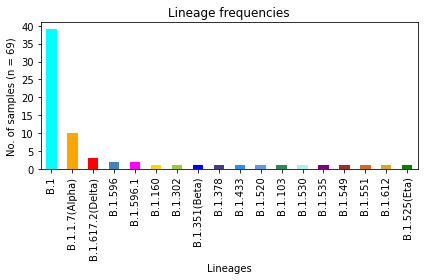

In [93]:
import math
# plot lineage frequencies
colors = [clr_code[lin][1] for lin in lins]
n = df_report_fnl['Pango Lineage Annotation'].count()
yticks = np.arange(0, (math.ceil(max_count / 5) + 1) * 5, 5)
fig, ax = plt.subplots()
(df_report_fnl['Pango Lineage Annotation']
 .value_counts()
 .plot(kind='bar', ax=ax, color=colors))
plt.title('Lineage frequencies')
plt.xlabel('Lineages')
plt.yticks(yticks)
plt.xticks(ticks=range(len(lins)), rotation=90, labels=xlabels)
plt.ylabel(f'No. of samples (n = {n})')
plt.tight_layout()
# fig.savefig('/home/douso/SarsGenomics/Processed/policy-brief-P006.png', dpi=300.0)
plt.show()